# 08. PyT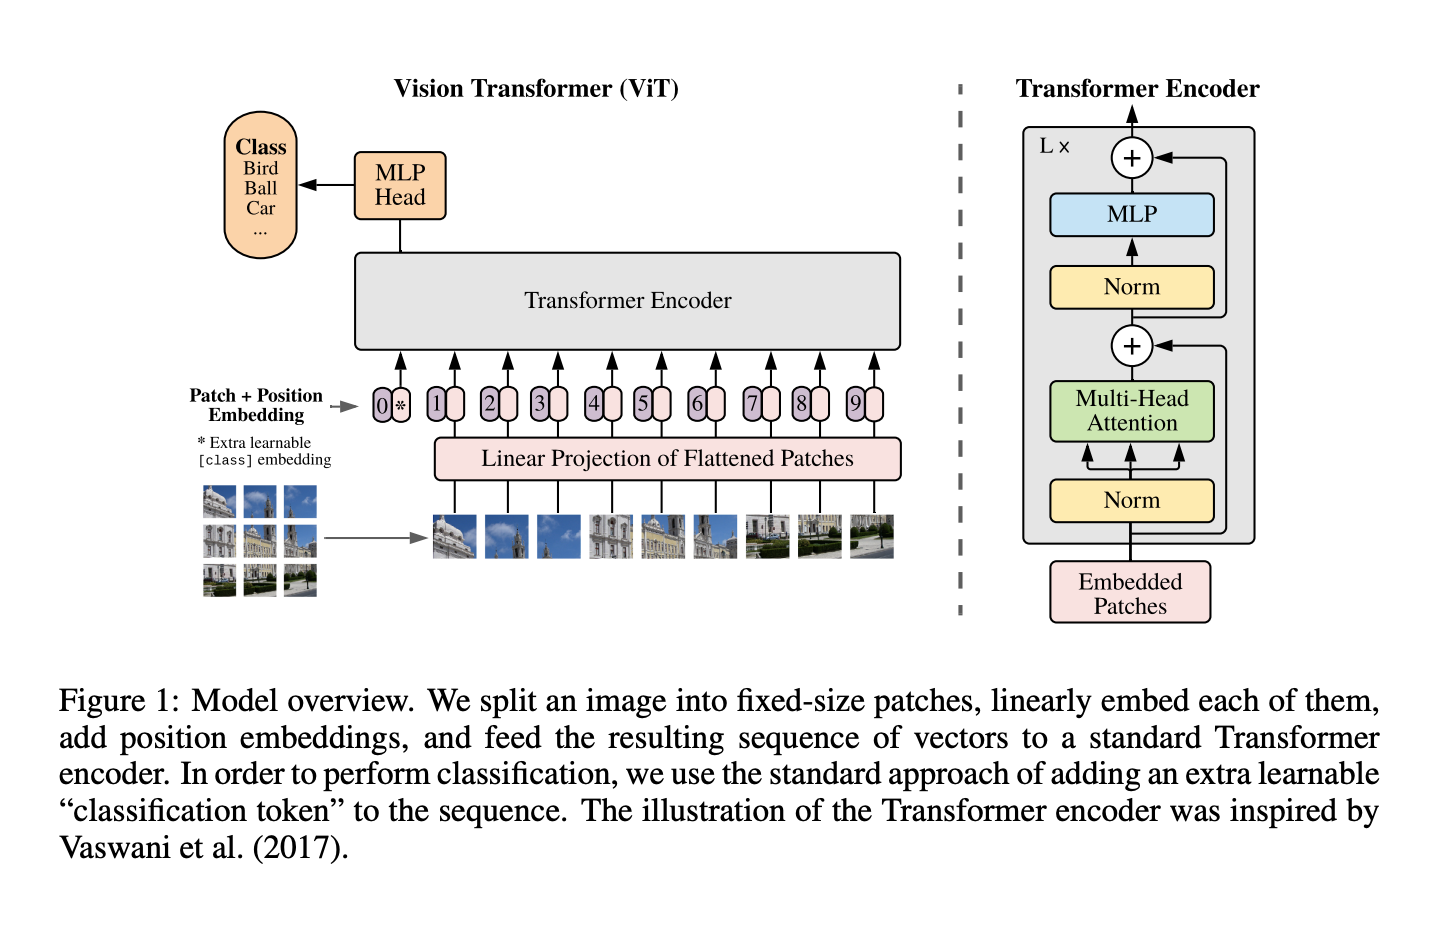

#### Import torch and torchvision

In [ ]:
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12 or int(torch.__version__.split(".")[0]) == 2, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

torch version: 2.1.0+cu121
torchvision version: 0.16.0+cu121


#### Import other pachages(going modular ...)

In [ ]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4056, done.
remote: Counting objects: 100% (1234/1234), done.
remote: Compressing objects: 100% (110/110), done.
remote: Total 4056 (delta 1141), reused 1124 (delta 1124), pack-reused 2822
Receiving objects: 100% (4056/4056), 649.94 MiB | 41.08 MiB/s, done.
Resolving deltas: 100% (2386/2386), done.
Updating files: 100% (248/248), done.


In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

### Download images

In [ ]:
# Download pizza, steak, sushi images from GitHub
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] Did not find data/pizza_steak_sushi directory, creating one...
[INFO] Downloading pizza_steak_sushi.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip...
[INFO] Unzipping pizza_steak_sushi.zip data...


PosixPath('data/pizza_steak_sushi')

In [ ]:
# Setup directory paths to train and test images
train_dir = image_path / "train"
test_dir = image_path / "test"

#### 2.0 Create Datasets and DataLoaders

In [ ]:
import os

# create an image size, use image size in 'an image is worth 16 x 16 words' -> 224
IMAGE_SIZE = 224 # Table 3 of ViT paper
BATCH_SIZE = 32

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

manual_transform = transforms.Compose([
        transforms.Resize(size=(IMAGE_SIZE, IMAGE_SIZE)),
        transforms.ToTensor(),
        # normalize
    ])

train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transform,
    batch_size=BATCH_SIZE,
    )

In [ ]:
len(train_dataloader), len(test_dataloader), class_names

(8, 3, ['pizza', 'steak', 'sushi'])

### 2.1 Visualize a single image

In [ ]:
# Get a batch of images
image_batch, label_batch = next(iter(train_dataloader))

# Get a single image from the batch
image, label = image_batch[0], label_batch[0]

# View the batch shapes
image.shape, label

(torch.Size([3, 224, 224]), tensor(1))

(-0.5, 223.5, 223.5, -0.5)

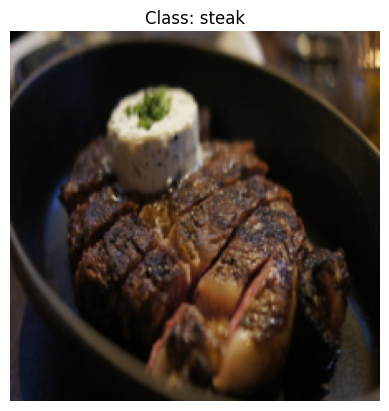

In [ ]:
plt.imshow(image.permute(1,2,0))
plt.title(f"Class: {class_names[label]}")
plt.axis(False)

## 3.0 Replocating ViT: Overview

When implementing a reseach paper, we want to identify:

* inputs()
* outputs
* layers

### 3.1 ViT overview: pieces of the puzzle

* Figure 1: Visual overview of the architecture
* Four equations: math equations which define the functions of each layer/block
* Table 1/3: different hyperparameters for the architecture/training.
* Text



---


### Figure 1

---


![](https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-figure-1-architecture-overview.png)

* Embedding = learnable representation (start with random numbers and imporve them over time)


---







### Four equations


![](https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-four-equations.png)

#### Section 3.1 describes the various equations
**Equation 1:**
An overview of the model is depicted in Figure 1. The standard Transformer receives as input a ID sequence of token embeddings. To handle $2 \mathrm{D}$ images, we reshape the image $\mathbf{x} \in \mathbb{R}^{H \times W \times C}$ into a sequence of flattened 2D patches $\mathbf{x}_p \in \mathbb{R}^{N \times\left(P^2 \cdot C\right)}$, where $(H, W)$ is the resolution of the original image, $C$ is the number of channels, $(P, P)$ is the resolution of each image patch, and $N=H W / P^2$ is the resulting number of patches, which also serves as the effective input sequence length for the Transformer. The Transformer uses constant latent vector size $D$ through all of its layers, so we flatten the patches and map to $D$ dimensions with a trainable linear projection (Eq. 1). We refer to the output of this projection as the patch embeddings.
<!-- \begin{aligned}
\mathbf{z}_0 & =\left[\mathbf{x}_{\text {class }} ; \mathbf{x}_p^1 \mathbf{E} ; \mathbf{x}_p^2 \mathbf{E} ; \cdots ; \mathbf{x}_p^N \mathbf{E}\right]+\mathbf{E}_{p o s}, & & \mathbf{E} \in \mathbb{R}^{\left(P^2 \cdot C\right) \times D}, \mathbf{E}_{p o s} \in \mathbb{R}^{(N+1) \times D}
\end{aligned} -->

**Equation 1:**
Position embeddings are added to the patch embeddings to retain positional information. We use standard learnable 1D position embeddings, since we have not observed significant performance gains from using more advanced 2D-aware position embeddings (Appendix D.4). The resulting sequence of embedding vectors serves as input to the encoder.

*Now turn the equation into pseudocode*

In pseudocode:
```python
x_input = [class_token, image_patch_1, image_patch_2, ... image_patch_N] + [class_token_pos, image_patch_1_pos, image_patch_2_pos, ... image_patch_N_pos]
```



**Equation 2&3:**
The Transformer encoder (Vaswani et al., 2017) consists of alternating layers of multiheaded selfattention (MSA, see Appendix A) and MLP blocks (Eq. 2, 3). Layernorm (LN) is applied before every block, and residual connections after every block (Wang et al., 2019; Baevski \& Auli, 2019).


In pseudocode:
```python
# Equation 2
x_output_MSA_block = MSA_layer(LNorm(x_input)) + x_input

# Equation 3
x_output_MLP_block = MLP_layer(LNorm(x_output_MSA_block)) + x_output_MSA_block
```

**Equation 4:**
Similar to BERT's [class] token, we prepend a learnable embedding to the sequence of embedded patches ( $\left.\mathbf{z}_0^0=\mathbf{x}_{\text {class }}\right)$, whose state at the output of the Transformer encoder $\left(\mathbf{z}_L^0\right)$ serves as the image representation $y$ (Eq. 4). Both during pre-training and fine-tuning, a classification head is attached to $\mathbf{z}_L^0$. The classification head is implemented by a MLP with one hidden layer at pre-training time and by a single linear layer at fine-tuning time.

* MLP = multilayer perceptron - nn with X number of layers
* MLP = one hidden layer at training time
* MLP = single linear layer at fine-tuning time


In pseudocode:
```python
# Equation 4
encoder_output = Linear_layer(LayerNorm(x_output_MLP_block))
```



### Table 1
![](https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-table-1.png)

* ViT-Base, ViT-Large and ViT-Huge are all different sizes of the same model architecture.
* Layers $L$  - the number of transformer encoder layers
* Hidden size $D$ - the embedding size throughout the architecture
* MLP size - number of hidden units in the MLP
* Heads - the number of multihead self attention

## 4.0 Equation 1: Split data into patches and creating the class, position ad patch embeddig

We know that: Layers = input -> function -> output

What is the input shape?

What is the output shape?

* input shape: (224, 224, 3) -> single image -> (H, W C)
* output_shape:


**Equation 1:**
An overview of the model is depicted in Figure 1. The standard Transformer receives as input a ID sequence of token embeddings. To handle $2 \mathrm{D}$ images, we reshape the image $\mathbf{x} \in \mathbb{R}^{H \times W \times C}$ into a sequence of flattened 2D patches $\mathbf{x}_p \in \mathbb{R}^{N \times\left(P^2 \cdot C\right)}$, where $(H, W)$ is the resolution of the original image, $C$ is the number of channels, $(P, P)$ is the resolution of each image patch, and $N=H W / P^2$ is the resulting number of patches, which also serves as the effective input sequence length for the Transformer. The Transformer uses constant latent vector size $D$ through all of its layers, so we flatten the patches and map to $D$ dimensions with a trainable linear projection (Eq. 1). We refer to the output of this projection as the patch embeddings.

**Equation 1:**
Position embeddings are added to the patch embeddings to retain positional information. We use standard learnable 1D position embeddings, since we have not observed significant performance gains from using more advanced 2D-aware position embeddings (Appendix D.4). The resulting sequence of embedding vectors serves as input to the encoder.

* Input image: $H×W×C$
* Output image: $N×P^2⋅C$
* H = height
* W = width
* C = color channels
* P = patch size
* N = number of patches -> $N = HW / P^2$
* D = constant latent vector size / embedding dimension / hidden units

### 4.1 Calculate input and output shapes by hand

In [ ]:
# create example values
height = 224
width = 224
color_channels = 3
patch_size = 16

# calculate the number of patches
num_of_patches = int((height * width) / patch_size**2)
num_of_patches

196

In [ ]:
# input shape
embedding_layer_input_shape = (height, width, color_channels)
embedding_layer_output_shape = (num_of_patches, patch_size**2 * color_channels)

print(f'Input shape (single 2D image): {embedding_layer_input_shape}')
print(f'Output shape (single 1D sequence of patches): {embedding_layer_output_shape}')

Input shape (single 2D image): (224, 224, 3)
Output shape (single 1D sequence of patches): (196, 768)


### 4.2 Turning a single image into patches

Let's visualize!

(-0.5, 223.5, 223.5, -0.5)

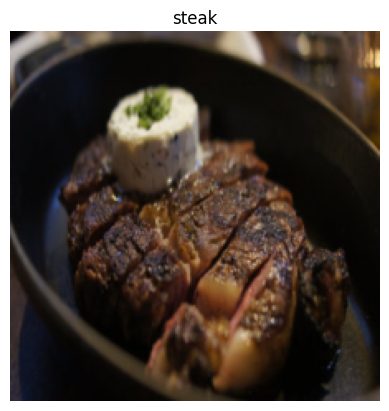

In [ ]:
plt.imshow(image.permute(1,2,0))
plt.title(class_names[label])
plt.axis(False)

In [ ]:
image.shape

torch.Size([3, 224, 224])

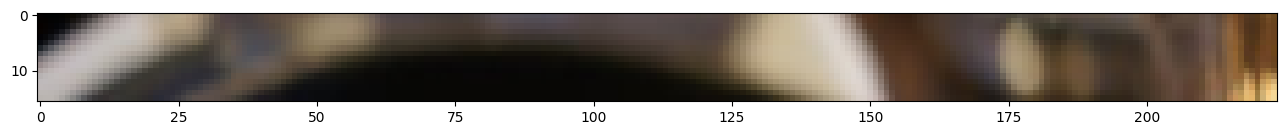

In [ ]:
# get the top row of image
image_permuted = image.permute(1, 2, 0)

# index to plot the top row of pixels
plt.figure(figsize=(patch_size, patch_size))
plt.imshow(image_permuted[:patch_size, :, :])

Number of patches per row: 14.0
Patch size: 16 pixels x 16 pixels


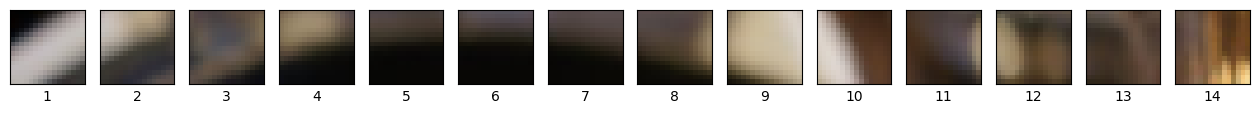

In [ ]:
# setup code to plot op row as patches
img_size = 224
num_patches = img_size / patch_size

assert img_size % patch_size == 0 , "Image size must be divisible by patch size"
print(f'Number of patches per row: {num_patches}\nPatch size: {patch_size} pixels x {patch_size} pixels')

# create a series of subplots
fig, axs = plt.subplots(nrows=1,
                        ncols=img_size // patch_size,
                        sharex=True, # columns will share the same x axis not hve their individual ones
                        sharey=True,
                        figsize=(patch_size, patch_size)
                        )

# iterate through number of patches in the top row
for i, patch in enumerate(range(0, img_size, patch_size)):
    axs[i].imshow(image_permuted[:patch_size, patch:patch + patch_size, :])
    axs[i].set_xlabel(i+1) # set patch label
    axs[i].set_xticks([])
    axs[i].set_yticks([])

Number of patches per row: 14.0        
Number of patches per column: 14.0        
Total patches: 196.0        
Patch size: 16 pixels x 16 pixels


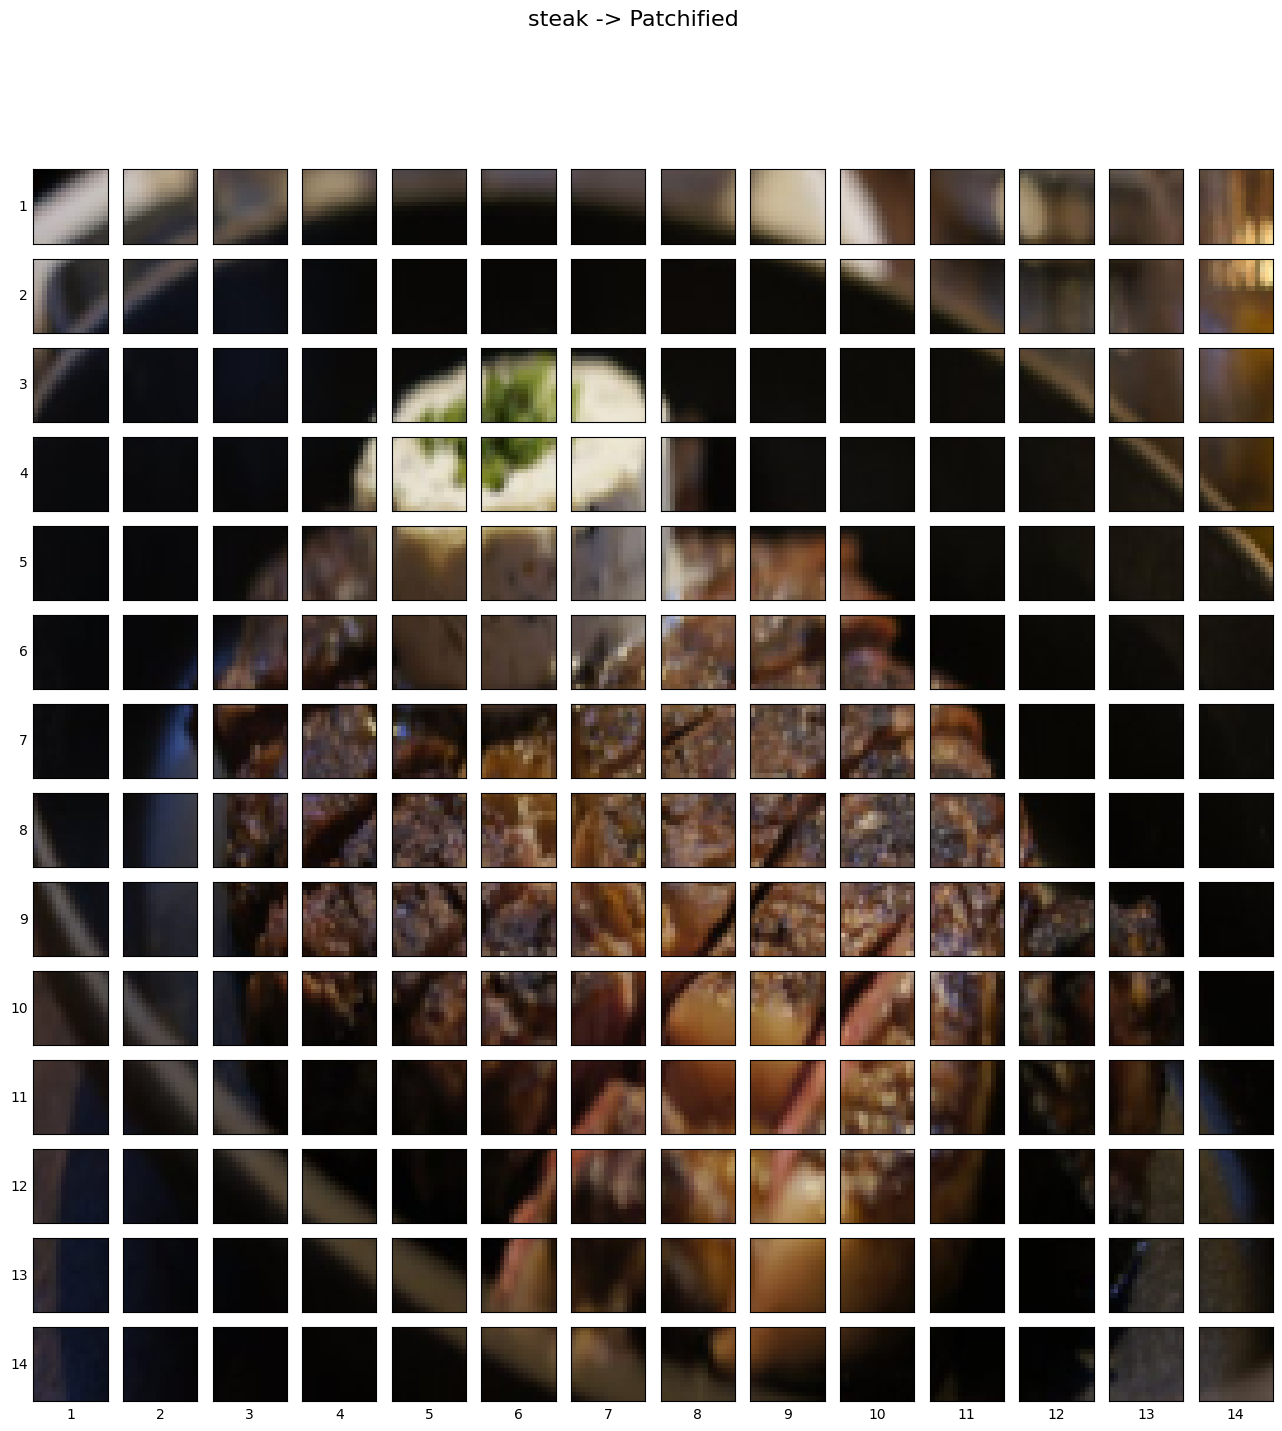

In [ ]:
# set up code to plot while image as patches
img_size = 224
num_patches = img_size / patch_size

assert img_size % patch_size == 0 , "Image size must be divisible by patch size"
print(f'Number of patches per row: {num_patches}\
        \nNumber of patches per column: {num_patches}\
        \nTotal patches: {num_patches*num_patches}\
        \nPatch size: {patch_size} pixels x {patch_size} pixels')

# create subplots
fig, axs = plt.subplots(nrows=img_size // patch_size,
                        ncols=img_size // patch_size,
                        sharex=True,
                        sharey=True,
                        figsize=(patch_size, patch_size))

# loop through height and width of the image
for row, r_patch in enumerate(range(0, img_size, patch_size)): # iterate through height
    for col, c_patch in enumerate(range(0, img_size, patch_size)): # iterate through width
    # plot the permuted image on the different axes
        axs[row, col].imshow(image_permuted[r_patch:r_patch + patch_size,
                                            c_patch:c_patch + patch_size,
                                            :])
        axs[row, col].set_ylabel(row+1,
                                 rotation='horizontal',
                                 horizontalalignment='right',
                                 verticalalignment='center')
        axs[row, col].set_xlabel(col+1) # set patch label

        axs[row, col].set_xticks([])
        axs[row, col].set_yticks([])
        axs[row, col].label_outer()

# Set a super title
fig.suptitle(f"{class_names[label]} -> Patchified", fontsize=16)
plt.show()

### 4.3 Creating image patches and turning them into patch embeddings

We can create the image patches and patch embeddings in a single step using nn.Conv2d and setting the kernel size and stride values to the patch size

In [ ]:
dummy = torch.randn(size=(1, 3, 224, 224))

conv2d = nn.Conv2d(in_channels=3,
              out_channels=768,
              kernel_size=patch_size,
              stride=patch_size,
              padding=0)
conv2d

Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))

In [ ]:
image_out_of_conv = conv2d(image.unsqueeze(0))
print(image_out_of_conv.shape)



torch.Size([1, 768, 14, 14])


In [ ]:
# torch.Size([1, 768, 14, 14]) -> batch, embedding dim, height, width

Showing random convolutional frature maps from indices: [462, 519, 594, 439, 279]


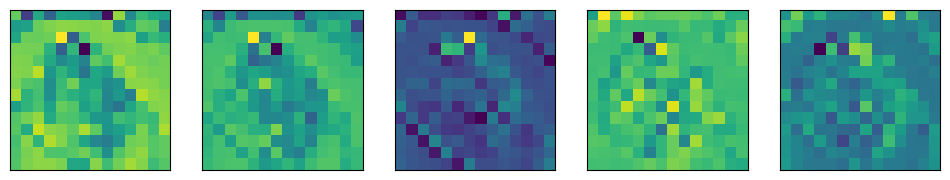

In [ ]:
# plot random convolutional feature maps/embeddings
import random

random_indices = random.sample(range(0, 768), k=5)
print(f'Showing random convolutional frature maps from indices: {random_indices}')

# create plot
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(12, 12))

# plot feature maps
for i, idx in enumerate(random_indices):
    img_feature_map = image_out_of_conv[:, # select entire batch
                                        idx, #select random index at idx
                                        :,# select entire height
                                        :] # select entire width
    axs[i].imshow(img_feature_map.squeeze().detach().numpy()) # remove batch dimension, and remove from grad tracking/ swithch to numpy for matplotlib
    axs[i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])


### 4.4 Flattening the patch embedding

In [ ]:
flattened_img = nn.Flatten(start_dim=2)(image_out_of_conv)
print(flattened_img.shape)

torch.Size([1, 768, 196])


In [ ]:
flatten_layer = nn.Flatten(start_dim=2)

Original image shape: torch.Size([3, 224, 224])
Image feature map shape: torch.Size([1, 768, 14, 14])
Flattened image feature map shapetorch.Size([1, 768, 196])


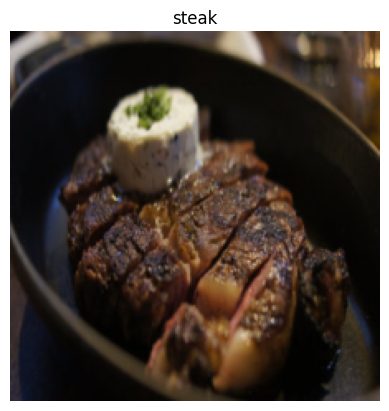

In [ ]:
# put everything together
plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False)
print(f'Original image shape: {image.shape}')

# turn image into feature maps
image_out_of_conv = conv2d(image.unsqueeze(0))
print(f'Image feature map shape: {image_out_of_conv.shape}')

# flatten feature maps
image_out_of_conv_flattened = flatten_layer(image_out_of_conv)
print(f'Flattened image feature map shape{image_out_of_conv_flattened.shape}')


In [ ]:
# rearrange output of flattened layer
print(f"{image_out_of_conv_flattened.permute(0, 2, 1).shape} -> batch_size, number of patches, embedding dimension")

torch.Size([1, 196, 768]) -> batch_size, number of patches, embedding dimension


In [ ]:
image_out_of_conv_flattened_permuted = image_out_of_conv_flattened.permute(0, 2, 1)

single_flattened_feature_map = image_out_of_conv_flattened_permuted[:,:,0]
single_flattened_feature_map.shape


torch.Size([1, 196])

(-0.5, 195.5, 0.5, -0.5)

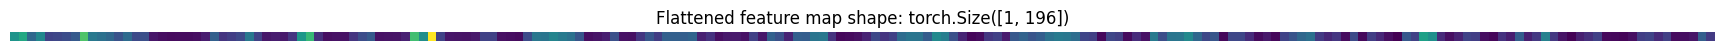

In [ ]:
# plot the flattened featire map visually
plt.figure(figsize=(22, 22))
plt.imshow(single_flattened_feature_map.detach().numpy())
plt.title(f'Flattened feature map shape: {single_flattened_feature_map.shape}')
plt.axis(False)

### 4.5 Turning the ViT patch embedding layer into a Pytorch module

We want this to do a few things:
1. Create a class called `Patch Embedding`
2. Initialize with appropriate hyperparameters, such as channels, embedding dimension, patch size.
3. Create a layer to turn an image into embedding patches using `nn.Conv2d()`
4.Create a layer to flatten the feature maps of the output of the layer in 3.
5. Define a `forward()` that defines the forward computation (e.g pass through layer from 3 and 4)
6. Make sure the output shape of the layer reflects the required output shape of the patch embedding.

In [ ]:
class PatchEmbedding(nn.Module):
    def __init__(self, input_channels=3, hidden_units=768, patch_size=16):
        super().__init__()
        self.patcher = nn.Conv2d(in_channels=input_channels, out_channels=hidden_units, kernel_size=patch_size, stride=patch_size, padding=0)
        self.flatten_layer = nn.Flatten(start_dim=2, end_dim=3)
        self.patch_size = patch_size

    def forward(self, x):
        # create assertion to check that inputs are correct shape
        image_resolution = x.shape[-1]
        assert image_resolution % patch_size == 0, f"Input image size must be divisible by patch size, image shape: {image_resolution}, patvh size: {self.patch_size}"

        # perform forward pass
        x_flattened = self.flatten_layer(self.patcher(x))
        x = x_flattened.permute(0, 2, 1)
        return x

In [ ]:
set_seeds()

# create an instance of patch embedding layer
patchify = PatchEmbedding(input_channels=3,
                          patch_size=16,
                          hidden_units=768).to(device)

# Pass a single image through
print(f"Input image shape: {image.unsqueeze(0).shape}")
patch_embedded_image = patchify(image.unsqueeze(0).to(device)) # add an extra batch dimension on the 0th index, otherwise will error
print(f"Output patch embedding shape: {patch_embedded_image.shape}")

Input image shape: torch.Size([1, 3, 224, 224])
Output patch embedding shape: torch.Size([1, 196, 768])


In [ ]:
patchify(dummy.to(device))

tensor([[[-0.3846, -0.5957,  0.6251,  ..., -0.2454, -0.4455,  0.0387],
         [-0.6935,  0.6553,  0.4244,  ..., -0.1710, -0.0530,  0.6466],
         [-0.1864,  0.5127,  0.1302,  ...,  1.3822,  1.0124,  0.4131],
         ...,
         [ 0.9068, -0.4676,  0.9459,  ..., -0.2596, -0.3591,  1.0305],
         [ 0.3233,  1.5363,  1.2173,  ...,  0.2963, -0.6432, -1.0543],
         [-0.5562, -0.5048, -0.8849,  ...,  0.6352, -0.4996,  0.0450]]],
       device='cuda:0', grad_fn=<PermuteBackward0>)

### 4.6 Creating the class token embedding

Want to: prepend a learnable class token to the start of the patch embedding

In [ ]:
batch_size = patch_embedded_image.shape[0]
embedding_dimension = patch_embedded_image.shape[2]
batch_size, embedding_dimension

(1, 768)

In [ ]:
# create a class token embedding as a as a learnable parameter(i.e requires grad) that shares the
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension),
                           requires_grad=True)
class_token.shape


torch.Size([1, 1, 768])

In [ ]:
# add the class token embedding to the front of the patch embedding
patch_embedded_image_with_class_embedding = torch.cat((class_token.to(device), patch_embedded_image.to(device)),
                                                      dim=1)# number of patches dimension
print(patch_embedded_image_with_class_embedding)
print(f'Sequence of patch embedding with class token prepended shape: {patch_embedded_image_with_class_embedding.shape} -> batchsize, class_token, number_of_patches')

tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
         [-0.6419,  0.2530, -0.2011,  ...,  0.3121, -0.0241,  0.1939],
         [-0.3971,  0.0378,  0.0111,  ...,  0.2745, -0.3247,  0.1434],
         ...,
         [-0.0951, -0.0165, -0.0439,  ...,  0.0144,  0.0036,  0.0440],
         [-0.2890,  0.0858, -0.1194,  ...,  0.1862, -0.0676,  0.0536],
         [-0.2062, -0.0100, -0.1148,  ...,  0.1803, -0.0701,  0.1215]]],
       device='cuda:0', grad_fn=<CatBackward0>)
Sequence of patch embedding with class token prepended shape: torch.Size([1, 197, 768]) -> batchsize, class_token, number_of_patches


### 4.7 Creating the positional embedding

Want to: create a series of learnable(requires grad) position embeddings and add them to the sequence of patch embeddings.

In [ ]:
# view the sequence of patch embeddings with prepended class embedding
patch_embedded_image_with_class_embedding, patch_embedded_image_with_class_embedding.shape

(tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
          [-0.6419,  0.2530, -0.2011,  ...,  0.3121, -0.0241,  0.1939],
          [-0.3971,  0.0378,  0.0111,  ...,  0.2745, -0.3247,  0.1434],
          ...,
          [-0.0951, -0.0165, -0.0439,  ...,  0.0144,  0.0036,  0.0440],
          [-0.2890,  0.0858, -0.1194,  ...,  0.1862, -0.0676,  0.0536],
          [-0.2062, -0.0100, -0.1148,  ...,  0.1803, -0.0701,  0.1215]]],
        device='cuda:0', grad_fn=<CatBackward0>),
 torch.Size([1, 197, 768]))

In [ ]:
# calculate number of patches
number_of_patches = int(height * width / patch_size**2)

# get embedding dim
embedding_dim = patch_embedded_image_with_class_embedding.shape[-1]

# create learnable 1D position embedding
position_embedding = nn.Parameter(torch.ones(1,
                                             number_of_patches+1,
                                             embedding_dim),
                                  requires_grad=True)
position_embedding, position_embedding.shape

(Parameter containing:
 tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]]], requires_grad=True),
 torch.Size([1, 197, 768]))

In [ ]:
# Add the position embedding to the patch and class token embedding
patch_and_position_embedding = patch_embedded_image_with_class_embedding.to(device) + position_embedding.to(device)
print(patch_and_position_embedding)
print(f"Patch and position embedding: {patch_and_position_embedding.shape}")

tensor([[[2.0000, 2.0000, 2.0000,  ..., 2.0000, 2.0000, 2.0000],
         [0.3581, 1.2530, 0.7989,  ..., 1.3121, 0.9759, 1.1939],
         [0.6029, 1.0378, 1.0111,  ..., 1.2745, 0.6753, 1.1434],
         ...,
         [0.9049, 0.9835, 0.9561,  ..., 1.0144, 1.0036, 1.0440],
         [0.7110, 1.0858, 0.8806,  ..., 1.1862, 0.9324, 1.0536],
         [0.7938, 0.9900, 0.8852,  ..., 1.1803, 0.9299, 1.1215]]],
       device='cuda:0', grad_fn=<AddBackward0>)
Patch and position embedding: torch.Size([1, 197, 768])


### 4.8 Putting layer/equ 1 all together

Weve written code to turn an image into a flattend sequence of patch embeddings.

Now let's see it all in one cell

In [ ]:
image.shape

torch.Size([3, 224, 224])

In [ ]:
# add batch dimension
x = image.unsqueeze(0)
print(f"Unsqueezed img shape: {x.shape}")

# create patch_embedding_layer
patch_embedding_layer = PatchEmbedding()
patch_embedding = patch_embedding_layer(x)
print(f"Patch embedding shape: {patch_embedding.shape}")

# crate the class token
batch_size = patch_embedding.shape[0]
embedding_dim = patch_embedding.shape[-1]
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dim),
                           requires_grad=True)
print(f"Class token shape: {class_token.shape}")


# prepend class token to beggining of patch embedding
patch_embedding_with_class_token = torch.cat((class_token, patch_embedding), dim=1)
print(f"Patch embedding with class token shape: {patch_embedding_with_class_token.shape}")

# Create and add positional embedding
position_embedding = nn.Parameter(torch.ones(1, number_of_patches+1, embedding_dim),
                           requires_grad=True)
patch_embedding_with_pos_embedding = patch_embedding_with_class_token + position_embedding
print(f"Patch embedding with class token and added posembedding shape: {patch_embedding_with_class_token.shape}")


Unsqueezed img shape: torch.Size([1, 3, 224, 224])
Patch embedding shape: torch.Size([1, 196, 768])
Class token shape: torch.Size([1, 1, 768])
Patch embedding with class token shape: torch.Size([1, 197, 768])
Patch embedding with class token and added posembedding shape: torch.Size([1, 197, 768])


In [ ]:
# turn image to patches
class Equation1(nn.Module):
    def __init__(self, in_channels, hidden_units, patch_size, batch_size, num_of_patches):
        super().__init__()
        self.patch_size = patch_size
        self.patcher = nn.Conv2d(in_channels=in_channels,
                                 out_channels=hidden_units,
                                 kernel_size=16, stride=16)
        self.flatten = nn.Flatten(start_dim=2, end_dim=3)
        self.class_token = nn.Parameter(torch.ones(batch_size, 1, hidden_units),
                                        requires_grad=True)
        self.positional_embedding = nn.Parameter(torch.ones(1,
                                                            num_of_patches+1,
                                                            hidden_units),
                                                 requires_grad=True)

    def forward(self, x):
        x = self.flatten(self.patcher(x))
        x_permuted = x.permute(0, 2, 1)
        x_with_class_token = torch.cat((self.class_token, x_permuted),
                                       dim=1)
        x_with_pos_embedding = x_with_class_token + self.positional_embedding
        return x_with_pos_embedding



## 5.0 Equation 2- Multihead Self Attention(MSA Block)

* MSA: which part of a sequence should pay attention to itself?
    * In our case, we have a series of embedded image patches, which patch signifcantly relates to another patch.
    * We want our NN (ViT) to learn this relationship/representation

* LayerNorm - is a technique to normalize the distributions of intermediate layers. It enables smoother gradients, faster training, and better generalization accuracy.
    * Normalization - make everything have the same mean and std.
    * In ouur case, we are normalizing values over $D$ dimension, which is the embedding dimension.
        * When we normalize alog the embedding dimension, it's like making all of the stairs in a staircase the same size.

In [ ]:
class MultiHeadSelfAttentionBlock(nn.Module):
    """Creates a multi-head self-attention block ('MSA block for short)"""
    def __init__(self,
                 embedding_dim:int=768, # Hidden size D (embedding dimension) from Table 1 for ViT-Base
                 num_heads:int=12, # Heads from Table 1 for ViT-Base
                 attn_dropout=0):
        super().__init__()
        # create norm layer
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

        # create msa layer
        self.msa = nn.MultiheadAttention(embed_dim=embedding_dim,
                                         num_heads=num_heads,
                                         dropout=attn_dropout,
                                         batch_first=True) # is the batch first? (batch, seq, feature) ->(batch, num_of_patche, embedding_dim)

    def forward(self, x):
        x = self.layer_norm(x)
        attn_output, _ = self.msa(query=x,
                                  key=x,
                                  value=x,
                                  need_weights=False)
        # + x
        return attn_output #+ x

In [ ]:
msa_block = MultiHeadSelfAttentionBlock()
patched_img_through_msa_block = msa_block(patch_embedding_with_pos_embedding)
print(f'Input shape of MSA block: {patch_embedding_with_pos_embedding.shape}')
print(f'Output shape of MSA block: {patched_img_through_msa_block.shape}')

Input shape of MSA block: torch.Size([1, 197, 768])
Output shape of MSA block: torch.Size([1, 197, 768])


## 6.0 Equation 3: MLP block

* **MLP** = The MLP contains 2 layers with GELU non-linearity (section 3.1).
    * MLP = a quite broad term for a block with a series of layers, layers can be multiple or even only one hidden layer.
    * Layers can mean: fully-connected, dense, linear, feed-forward, all are often similar names for the same thing, In PyTorch, thy're often callec `torch.nn.Linear()` and in Tensorflow they might be called `tf.keras.Dense()`
    * MLP number of hidden units = MLP size in table 1
* **Dropout** = Dropout, when used, is applide after every dense layer except for the qkv-projections and directly after adding positional to patch embeddings. Hybrid models are trianed with he exact setup as their ViT counterparts.
    * value for dropout available in table 3


In psedocode:
```python
# MLP
x = linear -> non-linear -> dropout -> linear -> dropout
```

In [ ]:
class MLPBlock(nn.Module):
    """Creates a multi-layer perceptron block ('MLP' block for short)"""
    def __init__(self,
                 embedding_dim:int=768, # Hidden size D (embedding dimension) from Table 1 for ViT-Base
                 mlp_size:int=3072, # MLP size from Table 1 for ViT-Base
                 dropout=0.1): # value for dropout available in table 3
        super().__init__()
        # create norm layer
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)
        self.mlp = nn.Sequential(
            nn.Linear(in_features=embedding_dim, out_features=mlp_size),
            nn.GELU(),
            nn.Dropout(p=dropout),
            nn.Linear(in_features=mlp_size, out_features=embedding_dim),
            nn.Dropout(p=dropout)
        )
    def forward(self, x):
        x = self.layer_norm(x)
        # MLP
        x = self.mlp(x)
        return x

In [ ]:
mlp_block = MLPBlock()
msa_patched_img_through_mlp_block = mlp_block(patched_img_through_msa_block)
print(f'Input shape of MLP block: {patched_img_through_msa_block.shape}')
print(f'Output shape of MLP block: {msa_patched_img_through_mlp_block.shape}')

Input shape of MLP block: torch.Size([1, 197, 768])
Output shape of MLP block: torch.Size([1, 197, 768])


## 7.0 Creating the Transformer Encoder

The Transformer Encoder is a combination of alternating blocks of MSA (equation 2) and MLP (equation 3)

And there are residual connections between each block.

* Encoder = turn a sequence into learnable representaion
* Decoder = go from learn representation back to some sort of sequence
* Residual connections = add a layer(s) input to  its subsequent output, this enables the creation of deeper networks (prevents weights from getting too small)

In pseudocode:
```python
# Transformer Encoder
x_input -> MSA_block -> [MSA_block_output + x_input] -> MLP_block -> [MLP_block_output + MSA_block_output + x_input] -> ...
# items in [] are vectors
```

### 7.1 Create a custom Transformer Encoder block

In [ ]:
class TransformerEncoderBlock(nn.Module):
    def __init__(self,
                 embedding_dim:int=768, # Hidden size D (embedding dimension) from Table 1 for ViT-Base
                 mlp_size:int=3072, # MLP size from Table 1 for ViT-Base
                 num_heads:int=12, # Heads from Table 1 for ViT-Base
                 attn_dropout=0,
                 dropout=0.1): # value for dropout available in table 3
        super().__init__()
        self.msa_block = MultiHeadSelfAttentionBlock(embedding_dim=embedding_dim,
                                                     num_heads=num_heads,
                                                     attn_dropout=attn_dropout)
        self.mlp_block = MLPBlock(embedding_dim=embedding_dim,
                                  mlp_size=mlp_size,
                                  dropout=dropout)

    def forward(self, x):
        x = self.msa_block(x) + x
        x = self.mlp_block(x) + x
        return x


In [ ]:
transformer_encoder_block = TransformerEncoderBlock()

# get summary
summary(model=transformer_encoder_block,
        input_size=(1, 197, 768),
        col_names=['input_size', 'output_size', 'num_params', 'trainable'],
        col_width=20,
        row_settings=['var_names'])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderBlock (TransformerEncoderBlock)  [1, 197, 768]        [1, 197, 768]        --                   True
├─MultiHeadSelfAttentionBlock (msa_block)          [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─MultiheadAttention (msa)                    --                   [1, 197, 768]        2,362,368            True
├─MLPBlock (mlp_block)                             [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─Sequential (mlp)                            [1, 197, 768]        [1, 197, 768]        --                   True
│    │    └─Linear (0)                     

### 7.2 Create a Transformer Encoder Layer with inbuilt PyTorch layers

So far we have created a transformer by hand.

But because of how good the transformer architecture is, PyTorch has implemented ready to use Transformer Encoder layerd.

We can create a Transformer Encoder with pure PyTorch layers

In [ ]:
# Create the same as above with torch.nn.TransformerEncoderLayer()
torch_transformer_encoder_layer = nn.TransformerEncoderLayer(d_model=768, # embedding size from Table 1
                                                             nhead=12,  # heads from Table 1
                                                             dim_feedforward=3072,  # MLP size from Table 1
                                                             dropout=0.1,
                                                             activation='gelu',
                                                             batch_first=True,
                                                             norm_first=True)
torch_transformer_encoder_layer

TransformerEncoderLayer(
  (self_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
  )
  (linear1): Linear(in_features=768, out_features=3072, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (linear2): Linear(in_features=3072, out_features=768, bias=True)
  (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (dropout1): Dropout(p=0.1, inplace=False)
  (dropout2): Dropout(p=0.1, inplace=False)
)

In [ ]:
summary(model=torch_transformer_encoder_layer,
        input_size=(1, 197, 768),
        col_names=['input_size', 'output_size', 'num_params', 'trainable'],
        col_width=20,
        row_settings=['var_names'])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderLayer (TransformerEncoderLayer)  [1, 197, 768]        [1, 197, 768]        7,087,872            True
Total params: 7,087,872
Trainable params: 7,087,872
Non-trainable params: 0
Total mult-adds (M): 0
Input size (MB): 0.61
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.61

## 8.0 Putting it all together

In [ ]:
class ViT(nn.Module):
    def __init__(self,
                 img_size=224, # Table 3 from ViT-Base
                 in_channels:int=3,
                 patch_size:int=16,
                 num_tansformer_layers:int=12, # Table 1 for "Layers" for ViT-Base
                 embedding_dim:int=768, # Hidden size D from Table 1 for ViT-Base
                 mlp_size:int=3072, # Table 1 for ViT-Base
                 num_heads:int=12, # Table 1 for ViT-Base
                 attn_dropout=0,
                 mlp_dropout=0.1,
                 embedding_dropout=0.1, # dropout for patch and position embeddings
                 num_classes:int=1000 # number of classes in our classification problem
                 ):
        super().__init__()

        # make an assertion that the image and patch size are compatible
        assert img_size % patch_size == 0, f"Image size must be divisible by patch size, image: {img_size}, patch_size: {patch_size}"

        # calculate the number of patches
        self.num_patches = (img_size * img_size) // patch_size ** 2

        # create learnable class embedding (needs to go at front of seqennce of patch embeddings)
        self.class_embedding = nn.Parameter(torch.randn(1, 1, embedding_dim),
                                            requires_grad=True)

        # create learnable position embedding
        self.position_embedding = nn.Parameter(torch.randn(1, self.num_patches+1, embedding_dim),
                                               requires_grad=True)

        # create embedding dropout value
        self.embedding_dropuout = nn.Dropout(p=embedding_dropout)

        # create patch embedding layer
        self.patch_embedding = PatchEmbedding(input_channels=in_channels,
                                              patch_size=patch_size,
                                              hidden_units=embedding_dim)

        # create the transformer encoder block
        self.transformer_encoder = nn.Sequential(*[TransformerEncoderBlock(embedding_dim=embedding_dim,
                                                                 mlp_size=mlp_size,
                                                                 num_heads=num_heads,
                                                                 attn_dropout=attn_dropout,
                                                                 dropout=mlp_dropout) for _ in range(num_tansformer_layers)])

        # create classifier head
        self.classifier = nn.Sequential(
            nn.LayerNorm(normalized_shape=embedding_dim),
            nn.Linear(in_features=embedding_dim, out_features=num_classes)
        )

    def forward(self, x):
        # get the batch size
        batch_size = x.shape[0]

        # create the class token embedding and expand it to match the batch size ( equ 1)
        class_token = self.class_embedding.expand(batch_size, -1, -1) # "-1" means to infer the dimensions

        # create patch embedding (equ 1)
        x = self.patch_embedding(x)

        # prepend class token (equ 1)
        x = torch.cat((class_token, x), dim=1)

        # add position embedding to class token and patch embedding
        x = self.position_embedding + x

        # apply dropout to patch embeddings
        x = self.embedding_dropuout(x)

        # pass data through transformer encoder(i.e msa and mlp blocks)(equ 2&3)
        x = self.transformer_encoder(x)

        # put the 0th index logit through the classifier(equ 4)
        x = self.classifier(x[:, 0]) # take all the batches, then the 0th index
        return x


In [ ]:
class_embedding = nn.Parameter(torch.randn(1, 1, 768),
                                            requires_grad=True)
class_embedding.shape

torch.Size([1, 1, 768])

In [ ]:
expanded = class_embedding.expand(32, -1, -1)
expanded.shape

torch.Size([32, 1, 768])

In [ ]:
vit = ViT()
vit

ViT(
  (embedding_dropuout): Dropout(p=0.1, inplace=False)
  (patch_embedding): PatchEmbedding(
    (patcher): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (flatten_layer): Flatten(start_dim=2, end_dim=3)
  )
  (transformer_encoder): Sequential(
    (0): TransformerEncoderBlock(
      (msa_block): MultiHeadSelfAttentionBlock(
        (layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (msa): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
      )
      (mlp_block): MLPBlock(
        (layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.1, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (1

In [ ]:
dummy = torch.randn(size=(1, 3, 224, 224))
vit(dummy).shape

torch.Size([1, 1000])

In [ ]:
# get summary
summary(model=vit,
        input_size=(1, 3, 224, 224),
        col_names=['input_size', 'output_size', 'num_params', 'trainable'],
        col_width=20,
        row_settings=['var_names'])

Layer (type (var_name))                                 Input Shape          Output Shape         Param #              Trainable
ViT (ViT)                                               [1, 3, 224, 224]     [1, 1000]            152,064              True
├─PatchEmbedding (patch_embedding)                      [1, 3, 224, 224]     [1, 196, 768]        --                   True
│    └─Conv2d (patcher)                                 [1, 3, 224, 224]     [1, 768, 14, 14]     590,592              True
│    └─Flatten (flatten_layer)                          [1, 768, 14, 14]     [1, 768, 196]        --                   --
├─Dropout (embedding_dropuout)                          [1, 197, 768]        [1, 197, 768]        --                   --
├─Sequential (transformer_encoder)                      [1, 197, 768]        [1, 197, 768]        --                   True
│    └─TransformerEncoderBlock (0)                      [1, 197, 768]        [1, 197, 768]        --                   True
│    │ 

### 8.1 Make the classes of ViT 3 instead of 1000

In [ ]:
vit_2 = ViT(num_classes=len(class_names)).to(device)

vit_2(dummy.to(device)).shape

torch.Size([1, 3])

## 9.0 Setting up code for custom ViT

### 9.1 create loss and optimizer functions

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=vit_2.parameters(),
                             lr=1e-3, betas=(0.9, 0.999),
                             weight_decay=0.1)

### 9.2 Train model

In [ ]:
from going_modular.going_modular.engine import train

vit_2_results = train(model=vit_2,
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=5,
                        device=device)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.4315 | train_acc: 0.3750 | test_loss: 2.4249 | test_acc: 0.1979
Epoch: 2 | train_loss: 1.3048 | train_acc: 0.2852 | test_loss: 2.6257 | test_acc: 0.2604
Epoch: 3 | train_loss: 1.3239 | train_acc: 0.4492 | test_loss: 2.1645 | test_acc: 0.1979
Epoch: 4 | train_loss: 1.3419 | train_acc: 0.4102 | test_loss: 1.4871 | test_acc: 0.1979
Epoch: 5 | train_loss: 1.1630 | train_acc: 0.2891 | test_loss: 1.0369 | test_acc: 0.5417


### 9.3 WHat is our training setup missing?

Previent underfitting:
* Data - our setup uses far less data (225 vs millions)

Prevent Overfitting:
* Learning warmup - start with a low learning rate and increase to a base LR
* Learning rate decay - as your model gets closer to convergence, start to lower the learning rate
* Gradient clipping - prevent gradients from getting too big

### 9.4 Plotting loss curves for our model

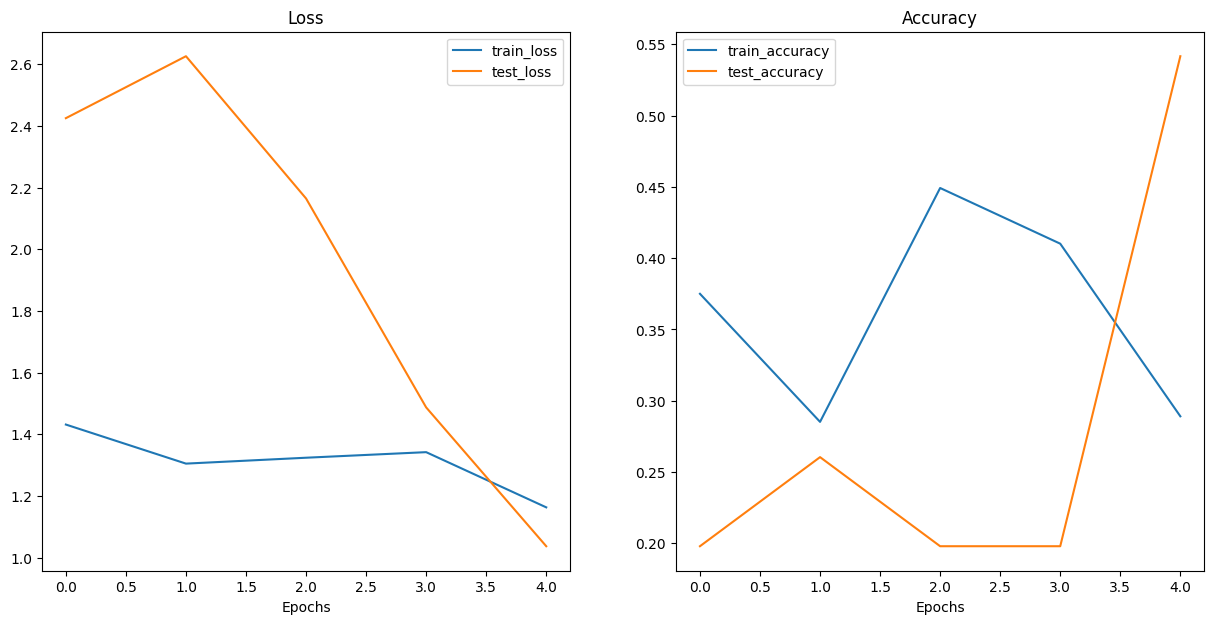

In [ ]:
from helper_functions import plot_loss_curves

plot_loss_curves(vit_2_results)

## 10 Transfer Learning

In [ ]:
from torchvision.models import ViT_B_16_Weights, vit_b_16

weights =  ViT_B_16_Weights.DEFAULT
model_0 = vit_b_16(weights=weights)

In [ ]:
# get summary
summary(model=model_0,
        input_size=(1, 3, 224, 224),
        col_names=['input_size', 'output_size', 'num_params', 'trainable'],
        col_width=20,
        row_settings=['var_names'])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 224, 224]     [1, 1000]            768                  True
├─Conv2d (conv_proj)                                         [1, 3, 224, 224]     [1, 768, 14, 14]     590,592              True
├─Encoder (encoder)                                          [1, 197, 768]        [1, 197, 768]        151,296              True
│    └─Dropout (dropout)                                     [1, 197, 768]        [1, 197, 768]        --                   --
│    └─Sequential (layers)                                   [1, 197, 768]        [1, 197, 768]        --                   True
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 197, 768]        [1, 197, 768]        7,087,872            True
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 197, 768]        [1, 197, 768

In [ ]:
for param in model_0.parameters():
    param.requires_grad = False

model_0.heads = nn.Sequential(
    nn.Linear(in_features=768, out_features=len(class_names))
)

In [ ]:
# get summary
summary(model=model_0,
        input_size=(1, 3, 224, 224),
        col_names=['input_size', 'output_size', 'num_params', 'trainable'],
        col_width=20,
        row_settings=['var_names'])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 224, 224]     [1, 3]               768                  Partial
├─Conv2d (conv_proj)                                         [1, 3, 224, 224]     [1, 768, 14, 14]     (590,592)            False
├─Encoder (encoder)                                          [1, 197, 768]        [1, 197, 768]        151,296              False
│    └─Dropout (dropout)                                     [1, 197, 768]        [1, 197, 768]        --                   --
│    └─Sequential (layers)                                   [1, 197, 768]        [1, 197, 768]        --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 197, 768]        [1, 197, 768]        (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 197, 768]        [1, 1

### 10.1 Train using pretrained model

In [ ]:
optimizer = torch.optim.Adam(params=model_0.parameters(),
                             lr=1e-3, betas=(0.9, 0.999),
                             weight_decay=0.1)
model_0_5_results = train(model=model_0,
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=10,
                        device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.1066 | train_acc: 0.9727 | test_loss: 0.2301 | test_acc: 0.9384
Epoch: 2 | train_loss: 0.0894 | train_acc: 0.9844 | test_loss: 0.2104 | test_acc: 0.9280
Epoch: 3 | train_loss: 0.0986 | train_acc: 0.9922 | test_loss: 0.2027 | test_acc: 0.9280
Epoch: 4 | train_loss: 0.0728 | train_acc: 0.9922 | test_loss: 0.2169 | test_acc: 0.9384
Epoch: 5 | train_loss: 0.0687 | train_acc: 1.0000 | test_loss: 0.1976 | test_acc: 0.9280
Epoch: 6 | train_loss: 0.0919 | train_acc: 0.9961 | test_loss: 0.1917 | test_acc: 0.9280
Epoch: 7 | train_loss: 0.0654 | train_acc: 0.9883 | test_loss: 0.1867 | test_acc: 0.9280
Epoch: 8 | train_loss: 0.0625 | train_acc: 1.0000 | test_loss: 0.1915 | test_acc: 0.9280
Epoch: 9 | train_loss: 0.0621 | train_acc: 1.0000 | test_loss: 0.1913 | test_acc: 0.9280
Epoch: 10 | train_loss: 0.0583 | train_acc: 1.0000 | test_loss: 0.1870 | test_acc: 0.9280


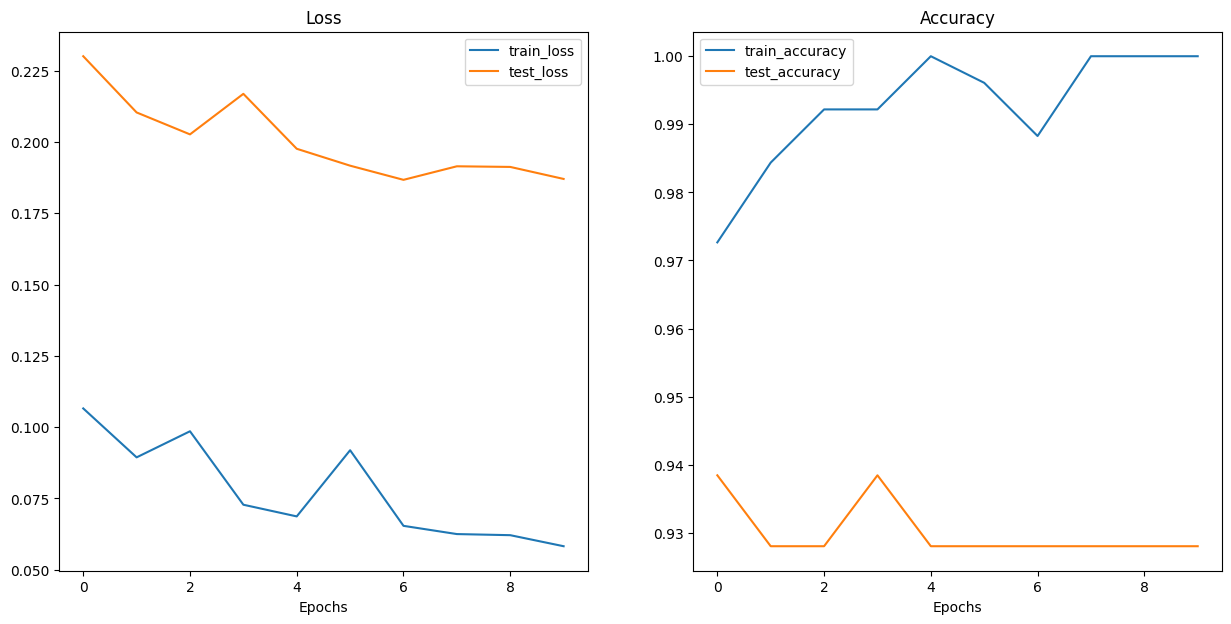

In [ ]:
plot_loss_curves(model_0_5_results)

### 10.2 Make data the same transform as pretrained model

In [ ]:
vit_transform = weights.transforms()
train_dataloader_vit, test_dataloader_vit, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                       test_dir=test_dir,
                                                                                       transform=vit_transform,
                                                                                       batch_size=32,
                                                                                       num_workers=os.cpu_count())

### 10.3 Train again

In [ ]:
optimizer = torch.optim.Adam(params=model_0.parameters(),
                             lr=1e-3, betas=(0.9, 0.999),
                             weight_decay=0.1)
model_0_results = train(model=model_0,
                        train_dataloader=train_dataloader_vit,
                        test_dataloader=test_dataloader_vit,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=10,
                        device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.0688 | train_acc: 0.9727 | test_loss: 0.1872 | test_acc: 0.9280
Epoch: 2 | train_loss: 0.0823 | train_acc: 0.9883 | test_loss: 0.1864 | test_acc: 0.9280
Epoch: 3 | train_loss: 0.0407 | train_acc: 0.9961 | test_loss: 0.1779 | test_acc: 0.9479
Epoch: 4 | train_loss: 0.1116 | train_acc: 0.9961 | test_loss: 0.1825 | test_acc: 0.9479
Epoch: 5 | train_loss: 0.0434 | train_acc: 1.0000 | test_loss: 0.2030 | test_acc: 0.9176
Epoch: 6 | train_loss: 0.0390 | train_acc: 1.0000 | test_loss: 0.2221 | test_acc: 0.8873
Epoch: 7 | train_loss: 0.0465 | train_acc: 1.0000 | test_loss: 0.2125 | test_acc: 0.8873
Epoch: 8 | train_loss: 0.0447 | train_acc: 1.0000 | test_loss: 0.1970 | test_acc: 0.9176
Epoch: 9 | train_loss: 0.0349 | train_acc: 1.0000 | test_loss: 0.2089 | test_acc: 0.9081
Epoch: 10 | train_loss: 0.0340 | train_acc: 1.0000 | test_loss: 0.2106 | test_acc: 0.9081


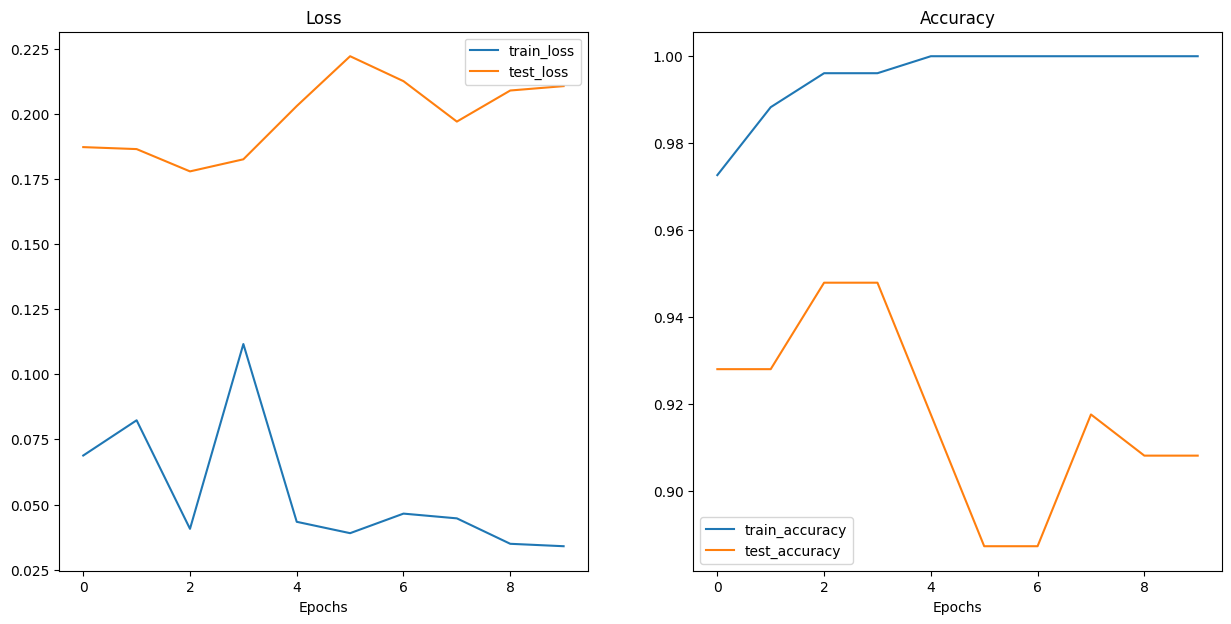

In [ ]:
plot_loss_curves(model_0_results)